In [1]:
import os ,yaml
from operator import itemgetter
from tools.import_data import *
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [2]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import feature_selection as fs

In [3]:
#Classes
class DataSet:
    def __init__(self,X,Y,feature_list,threshold=None,ratio=None):
        self.X = X
        self.Y = Y
        self.feature_list = feature_list
        self.threshold = threshold
        self.ratio = ratio

class SkFModel:
    def __init__(self,name,model):
        self.name=name
        self.model=model
        self.fited_model = None
    def fit_the_model(self):
        self.fited_model = train_the_model(X_train,Y_train,self.model)    
class TrainedModel:
    def __init__(self,train_set=DataSet,test_set=DataSet,model=SkFModel,train_score=float):
        self.train_set =train_set
        self.test_set = test_set
        self.chosen_model = model
        self.train_score = train_score
        self.test_score = None
    def test_the_model(self):
        test_the_data(self.train_set.X,self.train_set.Y,self.test_set.X,self.test_set.y,self.chosen_model)
    def set_chosen_model(self,name,fited_model):
        self.chosen_model=SkFModel(name,fited_model)
    

In [ ]:
def pre_processing(X_set,Y_set):
    # Data pre processing
    # Encoding Categorial features and imputing NaN's
    # https://chrisalbon.com/machine_learning/preprocessing_structured_data/convert_pandas_categorical_column_into_integers_for_scikit-learn/
    # http://pbpython.com/categorical-encoding.html
    # https://datascience.stackexchange.com/questions/14069/mass-convert-categorical-columns-in-pandas-not-one-hot-encoding
    char_cols = X_set.dtypes.pipe(lambda x: x[x == 'object']).index
    if not char_cols.empty:
        label_mapping = {}
        for c in char_cols:
            original_X_set = X_set.copy()
            X_set[c], label_mapping[c] = pd.factorize(X_set[c])
    imp = preprocessing.Imputer(axis=0, verbose=1)
    imp = imp.fit(X_set)
    X_set = imp.transform(X_set)
    
    lb = preprocessing.LabelBinarizer()
    Y_set = lb.fit_transform(Y_set).ravel()
    
    print ('Pre processing results: X_set-{} Y_set-{}'.format(X_set.shape,Y_set.shape))
    return X_set,Y_set

def get_models_CV_scores(X_train,Y_train,models):
    # Spot Check Algorithms with cross validation
    # evaluate each model in turn
    #TODO add the option to more score method
    scores = []
    names = []
    results = []
    for name, model in models:
        kfold = model_selection.StratifiedKFold(n_splits=10,shuffle=True)
        try:
            cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold,n_jobs=-1, scoring=SCORING )
            # cv_results = model_selection.GridSearchCV(model,scoring=SCORING)
            # cv_results.fit(X_train, Y_train)
        except ValueError as e:
            print('ValueError{}'.format(None))
        else:
            scores.append(cv_results)
            names.append(name)
            results.append({"model":SkFModel(name,model),"score":cv_results.mean()})
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(scores)
    ax.set_xticklabels(names)
    plt.show()
    return results
       
def test_the_data(X_test,Y_test,fited_model):
    # Make predictions on test dataset
    # results = []
    # for name, model in models:
    #     model.fit(X_train, Y_train)
    #     predictions = model.predict(X_test)
    #     results.append({"model":(name,model),"score":roc_auc_score(Y_test, predictions)})
    # return results 
    predictions = model.predict(X_test)
    # TODO dynamic score
    score = roc_auc_score(Y_test, predictions)
    return score
    

def get_the_best(results): # input - list of dict {"name":name,"score":score}
    m = max([k["score"] for k in results])
    i = [k["score"] for k in results].index(m)
    model = results[i]["model"]
    printmd('The best model for the given data is: <span style="color:green">' + str(model.name).format() + '</span> with the score <span style="color:green">' + str(m) + '</span>' )
    # print ('The best model for the given train (' + X_train.shape +') is: ' + name + 'with the score ' +m )
    return results[i] # the max model (dict type)


In [ ]:
def train_the_model(X_train,Y_train,non_fited_model=SkFModel):
    clf = non_fited_model.model
    clf.fit(X_train,Y_train)
    return clf

In [10]:
#consts
FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
CONFIG_FILE = os.path.join(FILE_PATH,'config.yml')
config = yaml.load(open(CONFIG_FILE,'r'))
TRAIN_FILE = config['files']['train_set']
TEST_FILE = config['files']['test_set']
SCORING = config['score']

models = []
    
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

if __name__ == "__main__":
    data_sets = []
    X_train, Y_train , original_headers_train = load_dataset(TRAIN_FILE) 
    data_sets.append({'X_train':X_train,'Y_train':Y_train,'original_headers_train':original_headers_train})
    print ('Train data shape: ', X_train.shape)
    print ('Train labels shape: ', Y_train.shape)
    X_train, Y_train = pre_processing(X_train,Y_train)   
    if TEST_FILE:
        X_test, Y_test ,original_headers_test = load_dataset(TEST_FILE)
        data_sets.append({'X_test':X_test,'Y_test':Y_test,'original_headers_test':original_headers_test})
        print ('Test data shape: ', X_test.shape)
        print ('Test labels shape: ', Y_test.shape)
        X_test, Y_test = pre_processing(X_test,Y_test)

Train data shape:  (776, 20)
Train labels shape:  (776,)
Pre processing results: X_set-(776, 20) Y_set-(776,)
Test data shape:  (398, 20)
Test labels shape:  (398,)
Pre processing results: X_set-(398, 20) Y_set-(398,)


In [11]:
    #create feature score list
    fs_scores = fs.mutual_info_classif(X_train,Y_train)
    feature_scores_list = []
    for i,score in enumerate(fs_scores):
        feature_scores_list.append({'feature_name':original_headers_train[i],'score':score})
    feature_scores_list.sort(key=itemgetter('score'),reverse=True)
    for feature in feature_scores_list:
        print (feature)

{'feature_name': 'SYM_YRS_SINCE_ACID_TASTE_START', 'score': 0.1175981777659254}
{'feature_name': 'SYM_TAKING_STOMACH_MEDS', 'score': 0.093604806044917943}
{'feature_name': 'WAIST_CIRCUMFERENCE', 'score': 0.079013257902759371}
{'feature_name': 'SYM_BURNING_CHEST', 'score': 0.071680829087304998}
{'feature_name': 'SEX', 'score': 0.058924978850094512}
{'feature_name': 'WEIGHT', 'score': 0.050121061965223035}
{'feature_name': 'HEIGHT', 'score': 0.049136403357215253}
{'feature_name': 'SYM_CHEST_PAIN', 'score': 0.043858990989350088}
{'feature_name': 'AGE', 'score': 0.043128601883137385}
{'feature_name': 'SYM_SLEEP_DISRUPTED', 'score': 0.040040968072797778}
{'feature_name': 'SYM_ACID_TASTE', 'score': 0.027389809888955563}
{'feature_name': 'PREFERRED_DRINK', 'score': 0.017234821226970842}
{'feature_name': 'ALC_UNITS_PER_WEEK_AGED_30', 'score': 0.014772148457963041}
{'feature_name': 'EDUCATION_LEVEL', 'score': 0.010837689699365161}
{'feature_name': 'SMK_AGE_SMOKING_STOPPED', 'score': 0.009870677

In [18]:
    #carate new 
    new_trains = []
    myrange = np.arange(0.01, 1, 0.01)
    for VTHRESH in myrange:  
        sel = fs.SelectPercentile(score_func=fs.mutual_info_classif,percentile=VTHRESH*100)
        X_train_mod = sel.fit_transform(X_train,Y_train)
        
        if len(new_trains) >= 1:
            if new_trains[-1]['ratio']!= X_train_mod.shape[-1]/X_train.shape[-1]:
                # TODO the same on the test set
                # new_range.append(VTHRESH)
                # new_trains.append(X_train_mod)
                # new_shapes_ratio.append(X_train_mod.shape[-1]/X_train.shape[-1])
                mask = sel.get_support() #list of booleans
                new_features = [] # The list of your K best features    
                for bool, feature in zip(mask, original_headers_train):
                    if bool:
                        new_features.append(feature)
                new_trains.append(DataSet(X_train_mod,
                                          Y_train,
                                          new_features,
                                          VTHRESH,
                                          X_train_mod.shape[-1]/X_train.shape[-1],
                                          )
                                  )
                
        else:
            # TODO the same on the test set
            mask = sel.get_support() #list of booleans
            new_features = [] # The list of your K best features    
            for bool, feature in zip(mask, original_headers_train):
                if bool:
                    new_features.append(feature)
            new_trains.append(DataSet(X_train_mod,
                                          Y_train,
                                          new_features,
                                          VTHRESH,
                                          X_train_mod.shape[-1]/X_train.shape[-1],
                                          )
                                  )

TypeError: __init__() takes 4 positional arguments but 6 were given

In [13]:
    best_traind_models = []
    # new_trains.rever()
    new_models = []
    for train_set in new_trains:
        printmd("**Training Section** for: {} features ({})".format(str(train_set.X.shape[-1]),
                                                                    rain_set.feature_list)
        train_resultes = get_models_CV_scores(train_set.X,train_set.y,models)
        new_models.append({'train_set':train_set,'train_resultes':train_resultes})
        if train_resultes:   
            best_tr = get_the_best(train_resultes)
            best_traind_models.append(TrainedModel(train_set,
                                                   test_set,
                                                   best_tr['model'],
                                                   best_tr['score']
                                                   )
                                      )
            
# TODO replace best_tr_results in the next sections and defined the test set
        
            # best_tr_results.append({"model":best_tr['model'],
            #                         "score":best_tr['score'],
            #                         "num_fetures":int(train_set.X.shape[-1]),
            #                         'features_names':train_set['features_name']})
            
            for model in train_resultes:
                print (model['model'][0],model['score'])

**Training Section** for: 1 features (['SYM_YRS_SINCE_ACID_TASTE_START'])

TypeError: __init__() got multiple values for argument 'scoring'

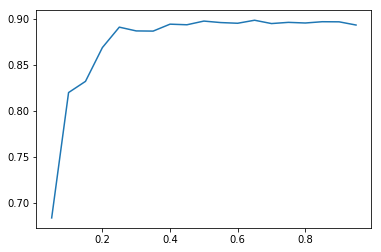

{'model': ('LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)), 'score': 0.89832619738751818, 'num_fetures': 13, 'features_names': ['AGE', 'SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'SMK_EVER_SMOKED', 'ALC_UNITS_PER_WEEK_AGED_30', 'ALC_DRINK_HEAVILY', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_ACID_TASTE_START', 'SYM_TAKING_STOMACH_MEDS']}
{'model': ('LR', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), 'score': 0.89741588050314469, 'num_fetures': 10, 'features_names': ['SEX', 'HEIGHT', 'WEIGHT', 'WAIST_CIRCUMFERENCE', 'ALC_UNITS_PER_WEEK_AGED_30', 'SYM_CHEST_PAIN', 'SYM_BURNING_CHEST', 'SYM_SLEEP_DISRUPTED', 'SYM_YRS_SINCE_ACID_TASTE_ST

In [9]:
    plt.plot([d['ratio'] for d in new_trains],
             [d['score'] for d in best_tr_results])
    plt.legend()
    plt.show()
    best_tr_results.sort(key=itemgetter('score'),reverse=True)
    for best in best_tr_results:
        print(best)

In [9]:
#need to modify the test shape
    printmd("**Testing Section:**")
    for bes
    test_results = test_the_data(X_train,Y_train,X_test,Y_test,chosen_model)
    best_ts = get_the_best(test_results)
    for model in test_results:
        print (model)


IndentationError: unexpected indent (<ipython-input-9-55d60a75eb15>, line 2)

In [9]:
    # #after we found the elbow
    # new_shape = []
    # range = np.arange(0.04, 0.17, 0.001)
    # for VTHRESH in range:  
    #     sel = fs.VarianceThreshold(VTHRESH)
    #     x = sel.fit_transform(X_train)
    #     new_shape.append(x.shape[-1])
    # plt.plot(range, new_shape)